# Forecasting sales of breakfast items in Apollo Hospitals using neural network

## Introduction

Using the [Practical Deep Learning for Coders](http://course.fast.ai/) course on fast.ai. 
The implementation is inspired by the [Lesson 3 Jupyter notebook](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson3-rossman.ipynb)

Especially the structured time series data. I use Python.

I chose to use a simple feed-forward neural network with entity embedding, since such models have been outperforming recurrent neural networks in recent times. For example, neural networks with categorical embedding have been successfully applied to time series data by the winners and 3rd place runners-up of the [New York City Taxi Fare Prediction](http://blog.kaggle.com/2015/07/27/taxi-trajectory-winners-interview-1st-place-team-%F0%9F%9A%95/) ([paper here](https://arxiv.org/abs/1508.00021)) and [Rosmann Store Sales](http://blog.kaggle.com/2016/01/22/rossmann-store-sales-winners-interview-3rd-place-cheng-gui/) ([paper here](https://arxiv.org/abs/1604.06737)) competitions on Kaggle. 

Using deep learning, the model requires just a single model. In contrast, classical ARIMA models are parametric and require determination of the ARIMA parameters for each breakfast item. 

## Preparations

### Load libraries and data files

 [fast.ai](https://github.com/fastai/fastai) library (built on top of Pytorch)

In [1]:
%matplotlib inline

# from fastai import *
from fastai.tabular import *

from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np

In [2]:
# Read sales data
df_ = pd.read_csv('./data/IMB.csv')
df_["Date"] = pd.to_datetime(df_.Date, format="%d/%m/%Y")

num_days = len(df_)
num_items = len(df_.columns[2:9])

print("Number of missing values: ", df_.isnull().sum().sum())
print("Shape: ",df_.shape)
df_.tail()

Number of missing values:  0
Shape:  (115, 9)


,Date,Occupancy,Idly,Dosa,Chutney,Sambar,Continental B/F,North Indian B/F,Omelette
110,2013-01-19,198,61,15,127,127,40,3,18
111,2013-01-20,210,65,20,140,140,41,3,22
112,2013-01-21,200,61,14,129,136,41,6,22
113,2013-01-22,230,66,17,128,123,43,7,21
114,2013-01-23,233,44,16,139,139,44,4,17


The raw dataset is composed of the sales numbers for 7 breakfast items, and a daily occupancy feature. The dataset is small, spanning less than four months from 1st October 2012 to 23rd January 2013. There are no missing values.

### Load external datasets

As before, the holiday data (drawn from [here](https://www.officeholidays.com/countries/india/tamil_nadu/index.php)) is included.

In [3]:
# Include holiday data (source: www.officeholidays.com)
holidays = pd.read_csv('./data/public_holidays_Tamil_Nadu.csv') 
holidays["Date"] = pd.to_datetime(holidays.Date, format="%d/%m/%Y")
dates = list(holidays['Date'])

for i in range(num_days):
    df_.loc[i,'Is_holiday'] = df_.loc[i,'Date'] in dates

### Data manipulation and feature engineering

The data is rearranged with a single target column (i.e. sales) with a new feature column for the item number. The advantage of neural networks is that multiple input features, such as occupancy, are easily included.

In [4]:
bkfst_map = {0:'Idly',1:'Dosa',2:'Chutney',3:'Sambar',4:'Continental B/F',
             5:'North Indian B/F',6:'Omelette'}
num_items = len(bkfst_map)

df = df_.loc[np.repeat(df_.index.values,num_items)]
df = df.reset_index(drop=True)

for i in range(num_days):
    for j in range(num_items):
        df.loc[num_items*i+j,'Item'] = j
        df.loc[num_items*i+j,'Sales'] = df_.loc[i,bkfst_map[j]]

df = df.drop(columns=["Idly","Dosa","Chutney","Sambar","Continental B/F",
                      "North Indian B/F", "Omelette",])        
        
df.tail(10)

,Date,Occupancy,Is_holiday,Item,Sales
795,2013-01-22,230,False,4.0,43.0
796,2013-01-22,230,False,5.0,7.0
797,2013-01-22,230,False,6.0,21.0
798,2013-01-23,233,False,0.0,44.0
799,2013-01-23,233,False,1.0,16.0
800,2013-01-23,233,False,2.0,139.0
801,2013-01-23,233,False,3.0,139.0
802,2013-01-23,233,False,4.0,44.0
803,2013-01-23,233,False,5.0,4.0
804,2013-01-23,233,False,6.0,17.0


In order to capture cyclical behaviour in time, a number of categorical features (such as month, day of week) are extracted from the date.

In [ ]:
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [5]:
add_datepart(df, "Date", drop=False)
df = df.drop(columns='Elapsed')
df = df.set_index('Date')
print(df.shape)
df.tail()

NameError: name 'add_datepart' is not defined

Create test set

In [7]:
test_days = 1
test_size = test_days*num_items

df_test = df[-test_size:]
df = df[:-test_size]

size = len(df); size

798

Continuous and categorical variables

Convert to input compatible with a neural network.

This includes converting categorical variables into contiguous integers or one-hot encodings, normalizing continuous features to standard normal, etc...

For continuous variables with small amounts of possible values (e.g. DoW), performance may be enhanced by treating the variable as categorical. 

In [14]:
# for v in cat_vars: df[v] = df[v].astype('category').cat.as_ordered()

In [15]:
# apply_cats(df_test, df)

In [17]:
# for v in contin_vars:
#     df[v] = df[v].astype('float32')
#     df_test[v] = df_test[v].astype('float32')

normalization of continuous features, apply same normalization to test set.

In [18]:
# X, y, nas, mapper = proc_df(df, dep, do_scale=True)

In [19]:
# X_test, _, nas, mapper = proc_df(df_test, dep, do_scale=True,
#                                   mapper=mapper, na_dict=nas)

validation set

In [20]:
# val_size = test_size
# val_idx = np.arange(size-val_size,size)

In [23]:
tfms = [FillMissing, Categorify]

In [9]:
val_size = test_size
df_train, df_val = df[:-val_size], df[-val_size:]

In [24]:
dep_var = 'Sales'
cat_names = ['Item', 'Is_holiday', 'Date']
# cat_names = ['Item', 'Is_holiday', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 
#             'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']

## Deep learning

Convert DataFrame into ModelData object, which contains data loaders for the training, validation, and test sets.

In [27]:
data = TabularDataBunch.from_df("/home/richard/ML Projects/", df_train, df_val, dep_var, tfms=tfms, cat_names=cat_names)

# md = ColumnarModelData.from_data_frame("/home/richard/ML Projects/", val_idx, X, y.astype(np.float32), cat_flds=cat_vars, bs=1,
#                                        test_df=X_test)

There is a general lack of information about the meals. For example, we have no data indicating the price, size or nutritional values of a meal, what region of India it's from, and whether it's spicy or plain, a soup or a salad. To compensate for this, we will use [categorical embedding](http://www.fast.ai/2018/04/29/categorical-embeddings/) to capture relationships between the categorical variables, in a manner analogous to word embeddings. For example, meal type is represented as a multi-dimensional vector. Each dimension may be thought of as learnable semantic information about the meal, that may end up representing "spiciness" or "soupiness".  Of course, each dimension will likely have multiple meanings in practice. Similarly, certain days of the week may have similar behaviour.  

In [29]:
cat_sz = [(c, len(df[c].cat.categories)+1) for c in cat_names]; cat_names

TypeError: 'TabularDataBunch' object is not subscriptable

In [22]:
# cat_sz = [(c, len(df[c].cat.categories)+1) for c in cat_vars]; cat_sz

[('Item', 8),
 ('Is_holiday', 3),
 ('Year', 3),
 ('Month', 5),
 ('Week', 18),
 ('Day', 32),
 ('Dayofweek', 8),
 ('Dayofyear', 115),
 ('Is_month_end', 3),
 ('Is_month_start', 3),
 ('Is_quarter_end', 3),
 ('Is_quarter_start', 3),
 ('Is_year_end', 3),
 ('Is_year_start', 3)]

The sizes of the embedding are calculated using the following rule of thumb (watch lesson 3 video).

In [23]:
# emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]; emb_szs

[(8, 4),
 (3, 2),
 (3, 2),
 (5, 3),
 (18, 9),
 (32, 16),
 (8, 4),
 (115, 50),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2)]

In [24]:
learn = get_tabular_learner(data, layers=[25,25], emb_szs={'native-country': 10}, metrics=[mean_absolute_error])

# m = md.get_learner(emb_szs, len(X.columns)-len(cat_vars), 0, 1, [25,25], [0,0])
# m.summary()

OrderedDict([('Embedding-1',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 4]),
                           ('trainable', True),
                           ('nb_params', 32)])),
             ('Embedding-2',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 2]),
                           ('trainable', True),
                           ('nb_params', 6)])),
             ('Embedding-3',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 2]),
                           ('trainable', True),
                           ('nb_params', 6)])),
             ('Embedding-4',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 3]),
                           ('trainable', True),
                           ('nb_params', 15)])),
             ('Embedding-5',
              OrderedDict([('input_shape', [-1]),
   

In [25]:
lr = 1e-3
learn.lr_find()
# lr_find(learn)

 64%|██████▍   | 510/791 [00:01<00:00, 335.73it/s, loss=1.34e+03]


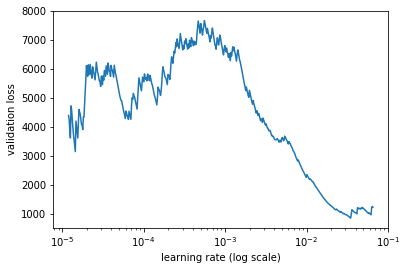

In [26]:
learn.recorder.plot()
# m.sched.plot()

Looks like X is a good learning rate.

In [28]:
learn.fit_one_cycle(7, 1e-3)
# m.fit(lr, 7, metrics=[mean_absolute_error])

epoch      trn_loss   val_loss   mean_absolute_error             
    0      505.274244 168.804835 10.685241 
    1      64.921048  50.000832  5.797965                    
    2      55.576869  59.627936  6.558801                    
    3      50.624207  61.195116  6.419994                    
    4      37.147549  37.493445  5.604567                    
    5      32.234002  65.267681  7.528493                    
    6      45.940128  57.080517  6.46456                     



[array([57.08052]), 6.464559623173305]

In [29]:
x,y = m.predict_with_targs()

In [30]:
x

array([[ 62.15335],
       [ 26.75789],
       [135.66386],
       [136.1527 ],
       [ 42.3539 ],
       [  3.57206],
       [ 14.24322]], dtype=float32)

Plot learned catergorical embeddings. t-SNE of categories see winners of other competitions.

In [31]:
y

array([[ 66.],
       [ 17.],
       [128.],
       [123.],
       [ 43.],
       [  7.],
       [ 21.]], dtype=float32)

## Conclusions

For a more accurate overall prediction, the results of the deep neural network and the ARIMA model could be ensemble averaged.

It is impressive that the deep neural network performed so well, given just 115 days of data. Nonetheless, the model would be much improved with more data in time. Also, capture more details at the point of sale such as patient information. 

Multiple hospital locations could be included using another feature column. 

include number of in-patients on specific diets
include weather, pollution levels
record patient information and activity
a dish could sell out, include an indicator for this. a predictive model could equivalently avoid dishes selling out, and dissatisfied patients.